# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def fmt_items(lines,max_lines=0):
    max_width=max([len(line)for line in lines])
    empty =' '*max_width
    lines = [line.ljust(max_width)for line in lines]
    lines += [empty]*(max_lines - len(lines))
    return lines
    
def pp (*list):
    lines = [ str(item).split('\n') for item in list]
    max_lines=max([len(item)for  item in lines])
    lines = [fmt_items(item,max_lines=max_lines)for item in lines]
    lines_t= np.array(lines).T
    print('\n'.join([' '.join(line) for  line in lines_t]))


In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

==GRAD_CHECK== at (0,)  num = 6.000000000039306 anal = 6.0
Gradient check passed!
==GRAD_CHECK== at (0,)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1,)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!
==GRAD_CHECK== at (0, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (0, 1)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 1)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!


True

In [6]:
(array_sum(np.array([5.0, 2.0]))[0]-array_sum(np.array([1.0, 2.0]))[0])/4

1.0

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
import linear_classifer 
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
# assert np.isclose(probs[0], 1.0)

soft max = [2.06106005e-09 4.53978686e-05 9.99954600e-01]
[2.06106005e-09 4.53978686e-05 9.99954600e-01]
soft max = [1. 0. 0.]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [10]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
    
linear_classifer.cross_entropy_loss(probs, np.array(2))


soft max = [4.50940412e-05 6.69254912e-03 9.93262357e-01]


IndexError: too many indices for array

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [ ]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
linear_classifer.cross_entropy_loss(probs, 0)

In [9]:
loss, grad= linear_classifer.softmax_with_cross_entropy(np.array([1., 0., 0.]), 0)
loss1, grad1= linear_classifer.softmax_with_cross_entropy(np.array([3, 0, 0]), 0)
loss2, grad2 = linear_classifer.softmax_with_cross_entropy(np.array([-1, 0, 0]), 0)
print((loss1-loss2)/4)
print('loss,grad = ',loss, grad)

enter of the function =  [1. 0. 0.] 0
soft max = [0.57611688 0.21194156 0.21194156]


AttributeError: 'int' object has no attribute 'flatten'

In [22]:
# TODO Implement combined function orsoftmax and cross entropy and produces gradient #-2.0491237621641485

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([ 1,0,0], np.float))

enter of the function =  [1. 0. 0.] 1


AttributeError: 'int' object has no attribute 'flatten'

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [7]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
pp('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
pp('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions = [[ 1.  2. -1.  1.]]
targets =  [[2]]
loss , grand (prediction) =  3.5797242232074917 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]] 
                                                                                                    
loss , grand (prediction) =  3.5797283438783922 [[ 0.20603518  0.56005049 -0.97211673  0.20603106]] 
                                                                                                    
loss , grand (prediction) =  3.5797201026020242 [[ 0.20602864  0.5600551  -0.9721165   0.20603276]] 
                                                                                                    
==GRAD_CHECK== at (0, 0)  num = 0.20603190920009948 anal = 0.20603190919001857
loss , grand (prediction) =  3.579735424312667 [[ 0.2060296   0.56005772 -0.97211693  0.2060296 ]] 
                                                                                                   
loss , grand (prediction) =  3.5797130222008735 [[ 0.20603422  0

True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [8]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)


loss, dW = linear_classifer.linear_softmax(X, W, target_index)
pp(dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

loss , grand (prediction) =  2.1851824526038124 [[ 0.11245721 -0.48478057]  
                                                 [ 0.0413707   0.33095266]] 
[[-0.11245721  0.48478057] 
 [-0.07108652  0.81573323] 
 [ 0.15382791 -0.15382791]]
loss , grand (prediction) =  2.1851824526038124 [[ 0.11245721 -0.48478057]  
                                                 [ 0.0413707   0.33095266]] 
loss , grand (prediction) =  2.1851802034795016 [[ 0.11245522 -0.48478054]  
                                                 [ 0.04137079  0.33095453]] 
loss , grand (prediction) =  2.1851847017680486 [[ 0.11245921 -0.48478061]  
                                                 [ 0.0413706   0.33095079]] 
==GRAD_CHECK== at (0, 0)  num = -0.11245721367458826 anal = -0.11245721367093255
loss , grand (prediction) =  2.1851921482182326 [[ 0.11245725 -0.48478087]  
                                                 [ 0.04137071  0.33095291]] 
loss , grand (prediction) =  2.1851727569953874 [[ 0.11245718 -0.

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [9]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
==GRAD_CHECK== at (0, 0)  num = 0.009999999999940612 anal = 0.01
enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
==GRAD_CHECK== at (0, 1)  num = 0.02000000000022817 anal = 0.02
enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
==GRAD_CHECK== at (1, 0)  num = -0.009999999999940612 anal = -0.01
enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
==GRAD_CHECK== at (1, 1)  num = 0.009999999999940612 anal = 0.01
enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
==GRAD_CHECK== at (2, 0)  num = 0.009999999999940612 anal = 0.01
enter of L2  (3, 2) 0.01
enter of L2  (3, 2) 0.01
==GRAD_CHECK== at (2, 1)  num = 0.02000000000022817 anal = 0.02
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [77]:
# TODO: Implement LinearSoftmaxClassifier.fit function 
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
'''THERE WERE 10 EPOCHS   !!!!!
'''

log loss =  102666.15435186218
Epoch 0, loss: 11.437980
== W == 0.17624349407509313
log loss =  102665.83476725097
Epoch 1, loss: 11.437335
== W == 0.17324946509479744
log loss =  102665.51943287873
Epoch 2, loss: 11.436703
== W == 0.17030656280312612
log loss =  102665.20827632082
Epoch 3, loss: 11.436084
== W == 0.16741389584116895
log loss =  102664.90122679397
Epoch 4, loss: 11.435476
== W == 0.16457058893177176
log loss =  102664.59821511057
Epoch 5, loss: 11.434881
== W == 0.16177578257281844
log loss =  102664.29917363409
Epoch 6, loss: 11.434297
== W == 0.15902863273686396
log loss =  102664.0040362362
Epoch 7, loss: 11.433725
== W == 0.15632831057697363
log loss =  102663.71273825495
Epoch 8, loss: 11.433164
== W == 0.15367400213862537
log loss =  102663.42521645449
Epoch 9, loss: 11.432613
== W == 0.15106490807753659


'THERE WERE 10 EPOCHS   !!!!!\n'

[11.437980141859269, 11.43733544585312, 11.436703417823981, 11.436083805928662, 11.435476363380554, 11.434880848346916, 11.434297023848313, 11.433724657660111, 11.433163522216013, 11.432613394513575]


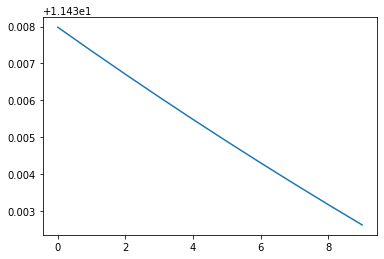

In [78]:
# let's look at the loss history!
print(loss_history)
plt.plot(loss_history)

In [90]:
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=300, learning_rate=1e-2, batch_size=300, reg=1e1)

log loss =  102667.07378251232
Epoch 0, loss: 11.438084
== W == -0.14154594529651654
log loss =  102663.88030036291
Epoch 1, loss: 11.431914
== W == -0.11774816524714836
log loss =  102661.07950375811
Epoch 2, loss: 11.426899
== W == -0.09799123333119203
log loss =  102658.6135801901
Epoch 3, loss: 11.422821
== W == -0.08159312001908484
log loss =  102656.43558205798
Epoch 4, loss: 11.419502
== W == -0.06798528987406666
log loss =  102654.50686999677
Epoch 5, loss: 11.416799
== W == -0.05669436627019166
log loss =  102652.79525163464
Epoch 6, loss: 11.414597
== W == -0.04732657521886578
log loss =  102651.27361187802
Epoch 7, loss: 11.412802
== W == -0.03955460935647236
log loss =  102649.91889284196
Epoch 8, loss: 11.411338
== W == -0.03310657681850522
log loss =  102648.71132432517
Epoch 9, loss: 11.410142
== W == -0.02775673159838126
log loss =  102647.6338353205
Epoch 10, loss: 11.409164
== W == -0.023317716648616267
log loss =  102646.67159757423
Epoch 11, loss: 11.408364
== W == 

log loss =  102638.3841799787
Epoch 95, loss: 11.404585
== W == -0.001492700181159391
log loss =  102638.38407629007
Epoch 96, loss: 11.404585
== W == -0.00149268826079505
log loss =  102638.38398309192
Epoch 97, loss: 11.404585
== W == -0.0014926775963509016
log loss =  102638.3838993227
Epoch 98, loss: 11.404585
== W == -0.0014926680539534838
log loss =  102638.38382402828
Epoch 99, loss: 11.404585
== W == -0.0014926595142708918
log loss =  102638.38375635108
Epoch 100, loss: 11.404585
== W == -0.0014926518708869353
log loss =  102638.38369552039
Epoch 101, loss: 11.404585
== W == -0.0014926450288646892
log loss =  102638.38364084344
Epoch 102, loss: 11.404585
== W == -0.0014926389034763288
log loss =  102638.38359169757
Epoch 103, loss: 11.404585
== W == -0.0014926334190787547
log loss =  102638.38354752319
Epoch 104, loss: 11.404585
== W == -0.0014926285081176232
log loss =  102638.38350781729
Epoch 105, loss: 11.404585
== W == -0.00149262411024419
log loss =  102638.38347212775
Ep

Epoch 187, loss: 11.404585
== W == -0.0014925862658024466
log loss =  102638.38315497493
Epoch 188, loss: 11.404585
== W == -0.0014925862653199723
log loss =  102638.38315496978
Epoch 189, loss: 11.404585
== W == -0.0014925862648878742
log loss =  102638.38315496517
Epoch 190, loss: 11.404585
== W == -0.0014925862645009
log loss =  102638.383154961
Epoch 191, loss: 11.404585
== W == -0.001492586264154344
log loss =  102638.38315495726
Epoch 192, loss: 11.404585
== W == -0.0014925862638439807
log loss =  102638.3831549539
Epoch 193, loss: 11.404585
== W == -0.0014925862635660463
log loss =  102638.38315495089
Epoch 194, loss: 11.404585
== W == -0.0014925862633171476
log loss =  102638.38315494817
Epoch 195, loss: 11.404585
== W == -0.00149258626309426
log loss =  102638.38315494572
Epoch 196, loss: 11.404585
== W == -0.0014925862628946643
log loss =  102638.38315494353
Epoch 197, loss: 11.404585
== W == -0.0014925862627159345
log loss =  102638.38315494155
Epoch 198, loss: 11.404585
== 

== W == -0.0014925862611873423
log loss =  102638.38315492398
Epoch 281, loss: 11.404585
== W == -0.0014925862611873295
log loss =  102638.383154924
Epoch 282, loss: 11.404585
== W == -0.0014925862611873146
log loss =  102638.383154924
Epoch 283, loss: 11.404585
== W == -0.0014925862611873076
log loss =  102638.38315492398
Epoch 284, loss: 11.404585
== W == -0.001492586261187296
log loss =  102638.383154924
Epoch 285, loss: 11.404585
== W == -0.001492586261187287
log loss =  102638.383154924
Epoch 286, loss: 11.404585
== W == -0.0014925862611872755
log loss =  102638.38315492398
Epoch 287, loss: 11.404585
== W == -0.0014925862611872701
log loss =  102638.383154924
Epoch 288, loss: 11.404585
== W == -0.001492586261187263
log loss =  102638.383154924
Epoch 289, loss: 11.404585
== W == -0.001492586261187254
log loss =  102638.383154924
Epoch 290, loss: 11.404585
== W == -0.001492586261187242
log loss =  102638.383154924
Epoch 291, loss: 11.404585
== W == -0.0014925862611872387
log loss = 

[11.438084378746636, 11.431914322588472, 11.42689917769524, 11.422820529940504, 11.419501594620423, 11.41679922021833, 11.414597443258607, 11.412802289083546, 11.411337574710734, 11.410141518538248, 11.409164000315744, 11.408364345612863, 11.407709533637929, 11.40717274697282, 11.406732197599315, 11.406370176290078, 11.406072282648507, 11.405826801302368, 11.405624196380224, 11.405456701741652, 11.405317988743295, 11.405202896803804, 11.405107214843081, 11.405027503944249, 11.40496095342466, 11.404905263988862, 11.404858552839029, 11.404819276591756, 11.40478616863796, 11.404758188220413, 11.404734479020012, 11.40471433546024, 11.404697175277963, 11.4046825171835, 11.404669962655051, 11.404659181093063, 11.40464989770604, 11.404641883617877, 11.40463494778265, 11.404628930370809, 11.40462369735373, 11.404619136064875, 11.404615151557268, 11.404611663610828, 11.40460860427031, 11.404605915816935, 11.40460354909478, 11.404601462127571, 11.404599618973608, 11.404597988775974, 11.404596544

(10, 12)

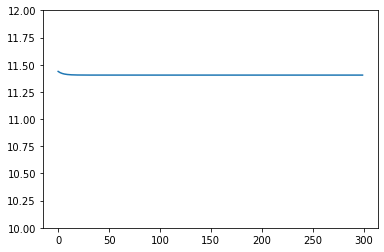

In [91]:
print(loss_history)
plt.plot(loss_history)
plt.gca().set_ylim(10,12)

log loss =  102670.7999651374
Epoch 0, loss: 11.438334
== W == 4915.78746514289


D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:38: RuntimeWarning: divide by zero encountered in log
  log =   np.sum(- np.log(probs[np.arange(probs.shape[0]),target_index.flatten()]))


log loss =  inf
Epoch 1, loss: inf
== W == -50685441.43709953
log loss =  inf
Epoch 2, loss: inf
== W == 506802194968.2201
log loss =  inf
Epoch 3, loss: inf
== W == -5067515149021195.0
log loss =  inf
Epoch 4, loss: inf
== W == 5.067008397506139e+19
log loss =  inf
Epoch 5, loss: inf
== W == -5.0665016966663887e+23
log loss =  inf
Epoch 6, loss: inf
== W == 5.065995046496721e+27
log loss =  inf
Epoch 7, loss: inf
== W == -5.065488446992072e+31
log loss =  inf
Epoch 8, loss: inf
== W == 5.064981898147372e+35
log loss =  inf
Epoch 9, loss: inf
== W == -5.064475399957558e+39
log loss =  inf
Epoch 0, loss: inf
== W == 5.063968952417561e+43
log loss =  inf
Epoch 1, loss: inf
== W == -5.06346255552232e+47
log loss =  inf
Epoch 2, loss: inf
== W == 5.0629562092667676e+51
log loss =  inf
Epoch 3, loss: inf
== W == -5.06244991364584e+55
log loss =  inf
Epoch 4, loss: inf
== W == 5.061943668654477e+59
log loss =  inf
Epoch 5, loss: inf
== W == -5.061437474287611e+63
log loss =  inf
Epoch 6, los

c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


log loss =  inf
Epoch 0, loss: inf
== W == 5.048799053279408e+163
log loss =  inf

D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:98: RuntimeWarning: overflow encountered in square
  loss = reg_strength * np.sum(W**2)



Epoch 1, loss: inf
== W == -5.04829417337408e+167
log loss =  inf
Epoch 2, loss: inf
== W == 5.0477893439567435e+171
log loss =  inf
Epoch 3, loss: inf
== W == -5.0472845650223474e+175
log loss =  inf
Epoch 4, loss: inf
== W == 5.0467798365658447e+179
log loss =  inf
Epoch 5, loss: inf
== W == -5.046275158582188e+183
log loss =  inf
Epoch 6, loss: inf
== W == 5.0457705310663305e+187
log loss =  inf
Epoch 7, loss: inf
== W == -5.045265954013223e+191
log loss =  inf
Epoch 8, loss: inf
== W == 5.044761427417822e+195
log loss =  inf
Epoch 9, loss: inf
== W == -5.0442569512750815e+199
log loss =  inf
Epoch 0, loss: inf
== W == 5.043752525579953e+203
log loss =  inf
Epoch 1, loss: inf
== W == -5.043248150327395e+207
log loss =  inf
Epoch 2, loss: inf
== W == 5.0427438255123615e+211
log loss =  inf
Epoch 3, loss: inf
== W == -5.042239551129811e+215
log loss =  inf
Epoch 4, loss: inf
== W == 5.041735327174698e+219
log loss =  inf
Epoch 5, loss: inf
== W == -5.04123115364198e+223
log loss =  i

D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:201: RuntimeWarning: overflow encountered in multiply
  self.W -= dW*learning_rate
c:\users\сергей\.virtualenvs\layman-s-deep-learning--lrbitjvr\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:100: RuntimeWarning: overflow encountered in multiply
  grad = reg_strength*W



Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, los

log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  n

log loss =  inf
Epoch 0, loss: inf
== W == -3.555386157224579e+272
log loss =  inf
Epoch 1, loss: inf
== W == 3.5518307710673546e+275
log loss =  inf
Epoch 2, loss: inf
== W == -3.548278940296287e+278
log loss =  inf
Epoch 3, loss: inf
== W == 3.544730661355991e+281
log loss =  inf
Epoch 4, loss: inf
== W == -3.541185930694635e+284
log loss =  inf
Epoch 5, loss: inf
== W == 3.537644744763939e+287
log loss =  inf
Epoch 6, loss: inf
== W == -3.534107100019176e+290
log loss =  inf
Epoch 7, loss: inf
== W == 3.530572992919157e+293
log loss =  inf
Epoch 8, loss: inf
== W == -3.5270424199262386e+296
log loss =  inf
Epoch 9, loss: inf
== W == 3.523515377506312e+299
log loss =  inf
Epoch 0, loss: inf
== W == -3.519991862128805e+302
log loss =  inf
Epoch 1, loss: inf
== W == 3.516471870266676e+305
log loss =  inf
Epoch 2, loss: inf
== W == -inf


D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:15: RuntimeWarning: overflow encountered in subtract
  s_pred =predictions-np.max(predictions)


log loss =  inf
Epoch 3, loss: inf
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  n

Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss

log loss =  inf
Epoch 8, loss: inf
== W == -2.879154869199745e+217
log loss =  inf
Epoch 9, loss: inf
== W == 2.850363320507748e+219
log loss =  inf
Epoch 0, loss: inf
== W == -2.82185968730267e+221
log loss =  inf
Epoch 1, loss: inf
== W == 2.793641090429643e+223
log loss =  inf
Epoch 2, loss: inf
== W == -2.765704679525347e+225
log loss =  inf
Epoch 3, loss: inf
== W == 2.7380476327300935e+227
log loss =  inf
Epoch 4, loss: inf
== W == -2.710667156402793e+229
log loss =  inf
Epoch 5, loss: inf
== W == 2.6835604848387643e+231
log loss =  inf
Epoch 6, loss: inf
== W == -2.6567248799903767e+233
log loss =  inf
Epoch 7, loss: inf
== W == 2.630157631190473e+235
log loss =  inf
Epoch 8, loss: inf
== W == -2.603856054878569e+237
log loss =  inf
Epoch 9, loss: inf
== W == 2.577817494329783e+239
log loss =  inf
Epoch 0, loss: inf
== W == -2.552039319386485e+241
log loss =  inf
Epoch 1, loss: inf
== W == 2.5265189261926205e+243
log loss =  inf
Epoch 2, loss: inf
== W == -2.501253736930694e+245

D:\Python\layman-s-Deep-Learning-\assignments\assignment1\linear_classifer.py:15: RuntimeWarning: invalid value encountered in subtract
  s_pred =predictions-np.max(predictions)


log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  nan
Epoch 6, loss: nan
== W == nan
log loss =  nan
Epoch 7, loss: nan
== W == nan
log loss =  nan
Epoch 8, loss: nan
== W == nan
log loss =  nan
Epoch 9, loss: nan
== W == nan
log loss =  nan
Epoch 0, loss: nan
== W == nan
log loss =  nan
Epoch 1, loss: nan
== W == nan
log loss =  nan
Epoch 2, loss: nan
== W == nan
log loss =  nan
Epoch 3, loss: nan
== W == nan
log loss =  nan
Epoch 4, loss: nan
== W == nan
log loss =  nan
Epoch 5, loss: nan
== W == nan
log loss =  n

log loss =  102638.39212512493
Epoch 6, loss: 11.404585
== W == -0.0010799306970847582
log loss =  102638.37686443982
Epoch 7, loss: 11.404584
== W == -0.0017990638669892253
log loss =  102638.38759484571
Epoch 8, loss: 11.404585
== W == -0.0012655476230026377
log loss =  102638.3800347917
Epoch 9, loss: 11.404584
== W == -0.0016604283403662285
log loss =  102638.38535484833
Epoch 0, loss: 11.404585
== W == -0.001368760057408545
log loss =  102638.38160710236
Epoch 1, loss: 11.404584
== W == -0.0015837790212344946
log loss =  102638.38424582212
Epoch 2, loss: 11.404585
== W == -0.001425539838997514
log loss =  102638.38238683227
Epoch 3, loss: 11.404585
== W == -0.0015418060336400518
log loss =  102638.38369623627
Epoch 4, loss: 11.404585
== W == -0.0014565044791253576
log loss =  102638.38277360107
Epoch 5, loss: 11.404585
== W == -0.001519002892709914
log loss =  102638.38342368805
Epoch 6, loss: 11.404585
== W == -0.0014732691709814336
log loss =  102638.38296552277
Epoch 7, loss: 1

log loss =  102638.383154924
Epoch 1, loss: 11.404585
== W == -0.0014925862611871435
log loss =  102638.38315492398
Epoch 2, loss: 11.404585
== W == -0.0014925862611871925
log loss =  102638.383154924
Epoch 3, loss: 11.404585
== W == -0.0014925862611872276
log loss =  102638.38315492398
Epoch 4, loss: 11.404585
== W == -0.001492586261187203
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.001492586261187214
log loss =  102638.383154924
Epoch 6, loss: 11.404585
== W == -0.0014925862611871888
log loss =  102638.383154924
Epoch 7, loss: 11.404585
== W == -0.0014925862611871905
log loss =  102638.383154924
Epoch 8, loss: 11.404585
== W == -0.0014925862611872259
log loss =  102638.383154924
Epoch 9, loss: 11.404585
== W == -0.0014925862611872072
log loss =  102638.383154924
Epoch 0, loss: 11.404585
== W == -0.001492586261187221
log loss =  102638.383154924
Epoch 1, loss: 11.404585
== W == -0.0014925862611872137
log loss =  102638.383154924
Epoch 2, loss: 11.404585
== W == -0

log loss =  102638.383154924
Epoch 8, loss: 11.404585
== W == -0.0014925862611871665
log loss =  102638.38315492398
Epoch 9, loss: 11.404585
== W == -0.0014925862611872248
log loss =  102638.383154924
Epoch 0, loss: 11.404585
== W == -0.0014925862611871602
log loss =  102638.383154924
Epoch 1, loss: 11.404585
== W == -0.0014925862611872356
log loss =  102638.383154924
Epoch 2, loss: 11.404585
== W == -0.0014925862611871816
log loss =  102638.38315492398
Epoch 3, loss: 11.404585
== W == -0.0014925862611872031
log loss =  102638.383154924
Epoch 4, loss: 11.404585
== W == -0.0014925862611871645
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.0014925862611872252
log loss =  102638.383154924
Epoch 6, loss: 11.404585
== W == -0.0014925862611872135
log loss =  102638.38315492398
Epoch 7, loss: 11.404585
== W == -0.0014925862611871814
log loss =  102638.383154924
Epoch 8, loss: 11.404585
== W == -0.0014925862611871715
log loss =  102638.38315492398
Epoch 9, loss: 11.404585
== 

log loss =  102657.54167266138
Epoch 4, loss: 11.419524
== W == -0.005051803125814363
log loss =  102655.46728013971
Epoch 5, loss: 11.416823
== W == -0.003939317791382083
log loss =  102653.632654055
Epoch 6, loss: 11.414621
== W == -0.0030673314116571315
log loss =  102652.0063529282
Epoch 7, loss: 11.412826
== W == -0.0023915410931257593
log loss =  102650.56198893918
Epoch 8, loss: 11.411361
== W == -0.0018746960401104726
log loss =  102649.27719607465
Epoch 9, loss: 11.410164
== W == -0.0014857430329906947
log loss =  102648.13285409039
Epoch 0, loss: 11.409186
== W == -0.0011989852078417105
log loss =  102647.11249703346
Epoch 1, loss: 11.408385
== W == -0.000993295982948745
log loss =  102646.2018561342
Epoch 2, loss: 11.407730
== W == -0.0008514088005064282
log loss =  102645.38850152814
Epoch 3, loss: 11.407192
== W == -0.0007592901859089854
log loss =  102644.66155748774
Epoch 4, loss: 11.406750
== W == -0.0007055957306413788
log loss =  102644.0114729995
Epoch 5, loss: 11.40

log loss =  102638.38385396331
Epoch 9, loss: 11.404585
== W == -0.001492391940978512
log loss =  102638.38378324898
Epoch 0, loss: 11.404585
== W == -0.0014924118925601613
log loss =  102638.38371968926
Epoch 1, loss: 11.404585
== W == -0.0014924297951119767
log loss =  102638.38366256018
Epoch 2, loss: 11.404585
== W == -0.001492445859149442
log loss =  102638.38361121099
Epoch 3, loss: 11.404585
== W == -0.0014924602735484382
log loss =  102638.38356505678
Epoch 4, loss: 11.404585
== W == -0.0014924732077711818
log loss =  102638.38352357195
Epoch 5, loss: 11.404585
== W == -0.0014924848138630163
log loss =  102638.38348628397
Epoch 6, loss: 11.404585
== W == -0.0014924952282436192
log loss =  102638.38345276818
Epoch 7, loss: 11.404585
== W == -0.0014925045733138894
log loss =  102638.38342264295
Epoch 8, loss: 11.404585
== W == -0.0014925129588974323
log loss =  102638.38339556518
Epoch 9, loss: 11.404585
== W == -0.001492520483533731
log loss =  102638.38337122656
Epoch 0, loss: 

log loss =  102638.38315495204
Epoch 4, loss: 11.404585
== W == -0.0014925862545781341
log loss =  102638.3831549492
Epoch 5, loss: 11.404585
== W == -0.0014925862552565819
log loss =  102638.38315494666
Epoch 6, loss: 11.404585
== W == -0.0014925862558653863
log loss =  102638.38315494436
Epoch 7, loss: 11.404585
== W == -0.001492586256411691
log loss =  102638.3831549423
Epoch 8, loss: 11.404585
== W == -0.0014925862569019229
log loss =  102638.38315494046
Epoch 9, loss: 11.404585
== W == -0.0014925862573418355
log loss =  102638.3831549388
Epoch 0, loss: 11.404585
== W == -0.001492586257736584
log loss =  102638.38315493731
Epoch 1, loss: 11.404585
== W == -0.0014925862580908123
log loss =  102638.38315493596
Epoch 2, loss: 11.404585
== W == -0.0014925862584086818
log loss =  102638.38315493475
Epoch 3, loss: 11.404585
== W == -0.0014925862586939102
log loss =  102638.38315493366
Epoch 4, loss: 11.404585
== W == -0.0014925862589498654
log loss =  102638.38315493269
Epoch 5, loss: 11

log loss =  102638.383154924
Epoch 9, loss: 11.404585
== W == -0.00149258626118697
log loss =  102638.383154924
Epoch 0, loss: 11.404585
== W == -0.0014925862611869895
log loss =  102638.38315492398
Epoch 1, loss: 11.404585
== W == -0.0014925862611870106
log loss =  102638.383154924
Epoch 2, loss: 11.404585
== W == -0.001492586261187035
log loss =  102638.383154924
Epoch 3, loss: 11.404585
== W == -0.00149258626118705
log loss =  102638.383154924
Epoch 4, loss: 11.404585
== W == -0.0014925862611870633
log loss =  102638.383154924
Epoch 5, loss: 11.404585
== W == -0.0014925862611870763
log loss =  102638.383154924
Epoch 6, loss: 11.404585
== W == -0.0014925862611870869
log loss =  102638.383154924
Epoch 7, loss: 11.404585
== W == -0.0014925862611870975
log loss =  102638.383154924
Epoch 8, loss: 11.404585
== W == -0.001492586261187106
log loss =  102638.38315492401
Epoch 9, loss: 11.404585
== W == -0.001492586261187115
log loss =  102667.135577723
Epoch 0, loss: 11.438502
== W == 0.2495

log loss =  102649.48904680824
Epoch 7, loss: 11.411020
== W == 0.05569071061489765
log loss =  102649.37223870485
Epoch 8, loss: 11.410901
== W == 0.05473148602413039
log loss =  102649.25670903153
Epoch 9, loss: 11.410784
== W == 0.053788444540723984
log loss =  102649.14244251559
Epoch 0, loss: 11.410670
== W == 0.05286131136146189
log loss =  102649.02942410178
Epoch 1, loss: 11.410558
== W == 0.05194981639293052
log loss =  102648.91763894819
Epoch 2, loss: 11.410448
== W == 0.05105369416956483
log loss =  102648.80707242226
Epoch 3, loss: 11.410340
== W == 0.05017268377315779
log loss =  102648.6977100971
Epoch 4, loss: 11.410234
== W == 0.04930652875380599
log loss =  102648.58953774752
Epoch 5, loss: 11.410130
== W == 0.04845497705226506
log loss =  102648.48254134656
Epoch 6, loss: 11.410028
== W == 0.0476177809236887
log loss =  102648.37670706167
Epoch 7, loss: 11.409928
== W == 0.04679469686272503
log loss =  102648.27202125153
Epoch 8, loss: 11.409830
== W == 0.04598548552

log loss =  102642.38072216797
Epoch 5, loss: 11.405699
== W == 0.009489337982835487
log loss =  102642.33964640673
Epoch 6, loss: 11.405680
== W == 0.009306905567413665
log loss =  102642.29899775615
Epoch 7, loss: 11.405662
== W == 0.009127523725977386
log loss =  102642.25877167251
Epoch 8, loss: 11.405644
== W == 0.008951141191880056
log loss =  102642.21896366277
Epoch 9, loss: 11.405626
== W == 0.00877770756391072
log loss =  102642.17956928385
Epoch 0, loss: 11.405609
== W == 0.008607173291609812
log loss =  102642.14058414203
Epoch 1, loss: 11.405592
== W == 0.008439489660835782
log loss =  102642.10200389236
Epoch 2, loss: 11.405575
== W == 0.008274608779578413
log loss =  102642.06382423812
Epoch 3, loss: 11.405558
== W == 0.008112483564014505
log loss =  102642.0260409302
Epoch 4, loss: 11.405542
== W == 0.00795306772480179
log loss =  102641.98864976646
Epoch 5, loss: 11.405526
== W == 0.007796315753606772
log loss =  102641.95164659122
Epoch 6, loss: 11.405510
== W == 0.00

log loss =  102639.87292074745
Epoch 1, loss: 11.404827
== W == 0.000728380198689216
log loss =  102639.85773415677
Epoch 2, loss: 11.404824
== W == 0.000691973675493179
log loss =  102639.84270318029
Epoch 3, loss: 11.404820
== W == 0.0006561701505326681
log loss =  102639.8278262091
Epoch 4, loss: 11.404817
== W == 0.0006209595648383947
log loss =  102639.8131016512
Epoch 5, loss: 11.404813
== W == 0.0005863320280892733
log loss =  102639.79852793131
Epoch 6, loss: 11.404810
== W == 0.0005522778157739001
log loss =  102639.78410349067
Epoch 7, loss: 11.404807
== W == 0.0005187873663999279
log loss =  102639.76982678688
Epoch 8, loss: 11.404804
== W == 0.0004858512787506526
log loss =  102639.75569629375
Epoch 9, loss: 11.404800
== W == 0.0004534603091878608
log loss =  102639.74171050102
Epoch 0, loss: 11.404797
== W == 0.0004216053690003123
log loss =  102639.7278679144
Epoch 1, loss: 11.404794
== W == 0.00039027752179687444
log loss =  102639.7141670551
Epoch 2, loss: 11.404791
== 

log loss =  102667.94533465113
Epoch 9, loss: 11.433602
== W == 0.3443998651678146
log loss =  102667.91144506328
Epoch 0, loss: 11.433546
== W == 0.3438169668522592
log loss =  102667.87760023188
Epoch 1, loss: 11.433490
== W == 0.3432350593181338
log loss =  102667.84380008116
Epoch 2, loss: 11.433435
== W == 0.34265414086173374
log loss =  102667.81004453546
Epoch 3, loss: 11.433379
== W == 0.34207420978234226
log loss =  102667.77633351937
Epoch 4, loss: 11.433324
== W == 0.34149526438222466
log loss =  102667.74266695761
Epoch 5, loss: 11.433268
== W == 0.34091730296662404
log loss =  102667.70904477504
Epoch 6, loss: 11.433213
== W == 0.34034032384375457
log loss =  102667.67546689675
Epoch 7, loss: 11.433158
== W == 0.3397643253247972
log loss =  102667.64193324797
Epoch 8, loss: 11.433103
== W == 0.3391893057238935
log loss =  102667.60844375408
Epoch 9, loss: 11.433048
== W == 0.33861526335814035
log loss =  102667.5749983407
Epoch 0, loss: 11.432993
== W == 0.3380421965475854

log loss =  102664.7961069592
Epoch 8, loss: 11.428573
== W == 0.29124285874791106
log loss =  102664.76630590689
Epoch 9, loss: 11.428527
== W == 0.2907502320474774
log loss =  102664.73654287298
Epoch 0, loss: 11.428481
== W == 0.29025844114183724
log loss =  102664.7068177966
Epoch 1, loss: 11.428435
== W == 0.2897674845982984
log loss =  102664.67713061703
Epoch 2, loss: 11.428390
== W == 0.28927736098666645
log loss =  102664.64748127363
Epoch 3, loss: 11.428344
== W == 0.2887880688792404
log loss =  102664.61786970597
Epoch 4, loss: 11.428298
== W == 0.2882996068508077
log loss =  102664.58829585367
Epoch 5, loss: 11.428253
== W == 0.28781197347864007
log loss =  102664.5587596565
Epoch 6, loss: 11.428208
== W == 0.2873251673424891
log loss =  102664.52926105443
Epoch 7, loss: 11.428162
== W == 0.28683918702458155
log loss =  102664.49979998745
Epoch 8, loss: 11.428117
== W == 0.2863540311096151
log loss =  102664.47037639571
Epoch 9, loss: 11.428072
== W == 0.28586969818475394
l

log loss =  102662.0211508933
Epoch 7, loss: 11.424432
== W == 0.2463116298961338
log loss =  102661.99483763339
Epoch 8, loss: 11.424395
== W == 0.24589517233323288
log loss =  102661.96855694815
Epoch 9, loss: 11.424357
== W == 0.2454794201712901
log loss =  102661.9423087881
Epoch 0, loss: 11.424319
== W == 0.24506437220437136
log loss =  102661.91609310379
Epoch 1, loss: 11.424281
== W == 0.24465002722863438
log loss =  102661.88990984598
Epoch 2, loss: 11.424244
== W == 0.24423638404232495
log loss =  102661.86375896544
Epoch 3, loss: 11.424206
== W == 0.24382344144577317
log loss =  102661.83764041308
Epoch 4, loss: 11.424169
== W == 0.24341119824139004
log loss =  102661.81155413992
Epoch 5, loss: 11.424132
== W == 0.24299965323366327
log loss =  102661.78550009706
Epoch 6, loss: 11.424094
== W == 0.2425888052291541
log loss =  102661.75947823568
Epoch 7, loss: 11.424057
== W == 0.24217865303649316
log loss =  102661.73348850706
Epoch 8, loss: 11.424020
== W == 0.241769195466377

TypeError: must be real number, not NoneType

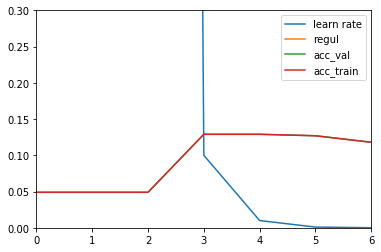

In [92]:
num_epochs = 300
batch_size = 300

learning_rates = [1e3, 1e2, 1e1,1e-1, 1e-2,1e-3, 1e-4,]
reg_strengths = [1e1]

best_classifier = None
best_val_accuracy = None

data:list = list()
train_val:list = list()

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
   
for l in learning_rates:
    for r in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        for i in range(0,num_epochs,10): 
            classifier.fit(train_X, train_y, epochs=10, learning_rate=l, batch_size=300, reg=r)
            pred_val = classifier.predict(val_X)
            pred_train = classifier.predict(train_X)
            accuracy_val = multiclass_accuracy(pred_val, val_y)
            accuracy_train = multiclass_accuracy(pred_train, val_y)
            train_val.append({'acc_val':accuracy_val,'acc_train':accuracy_val})
        data.append({'learn rate':l,'regul':r,'acc_val':accuracy_val,'acc_train':accuracy_val})
        


frame = pd.DataFrame(data)
tr_val = pd.DataFrame(train_val)
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,0.3)

# print('best validation accuracy achieved: %f' % best_val_accuracy)

     acc_val  acc_train
0      0.087      0.087
1      0.087      0.087
2      0.087      0.087
3      0.087      0.087
4      0.087      0.087
..       ...        ...
205    0.116      0.116
206    0.116      0.116
207    0.117      0.117
208    0.116      0.116
209    0.118      0.118

[210 rows x 2 columns]


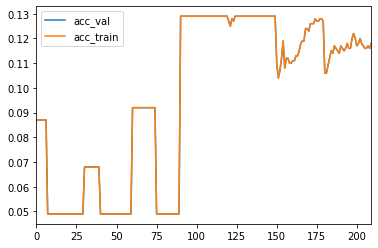

In [96]:
tr_val=pd.DataFrame(train_val)
tr_val.plot()
print(tr_val)

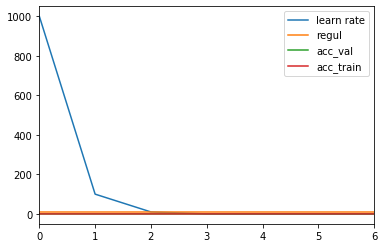

In [98]:
frame.plot()

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

      learn rate         regul  accuracy
0   1.000000e-04  1.000000e-07     0.089
1   1.000000e-04  1.000000e-08     0.112
2   1.000000e-04  1.000000e-09     0.117
3   1.000000e-04  1.000000e-10     0.081
4   1.000000e-04  1.000000e-11     0.131
5   1.000000e-05  1.000000e-07     0.089
6   1.000000e-05  1.000000e-08     0.123
7   1.000000e-05  1.000000e-09     0.078
8   1.000000e-05  1.000000e-10     0.116
9   1.000000e-05  1.000000e-11     0.102
10  1.000000e-06  1.000000e-07     0.083
11  1.000000e-06  1.000000e-08     0.088
12  1.000000e-06  1.000000e-09     0.108
13  1.000000e-06  1.000000e-10     0.107
14  1.000000e-06  1.000000e-11     0.091
15  1.000000e-07  1.000000e-07     0.112
16  1.000000e-07  1.000000e-08     0.092
17  1.000000e-07  1.000000e-09     0.113
18  1.000000e-07  1.000000e-10     0.131
19  1.000000e-07  1.000000e-11     0.094
20  1.000000e-08  1.000000e-07     0.096
21  1.000000e-08  1.000000e-08     0.110
22  1.000000e-08  1.000000e-09     0.101
23  1.000000e-08

Text(0.5, 0, 'accuracy')

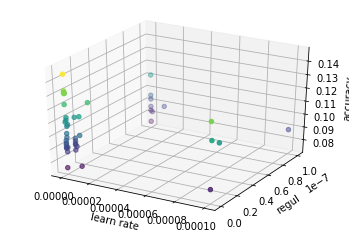

In [34]:
print(frame)
ax=plt.subplot(projection = '3d')
ax.scatter(frame['learn rate'],frame['regul'],frame['accuracy'],c = frame['accuracy'],cmap = 'viridis')
ax.set_xlabel('learn rate')
ax.set_ylabel('regul')
ax.set_zlabel('accuracy')

     learn rate    regul  accuracy
0  1.000000e-01  0.00001     0.088
1  1.000000e-02  0.00001     0.090
2  1.000000e-03  0.00001     0.083
3  1.000000e-04  0.00001     0.084
4  1.000000e-05  0.00001     0.084
5  1.000000e-06  0.00001     0.094
6  1.000000e-07  0.00001     0.100
7  1.000000e-08  0.00001     0.076
8  1.000000e-09  0.00001     0.136


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

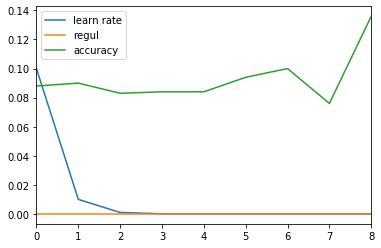

In [17]:
print(frame)
frame.plot()
plt.set_ylim(0,30)

     learn rate    regul  accuracy
0  1.000000e-01  0.00001     0.088
1  1.000000e-02  0.00001     0.090
2  1.000000e-03  0.00001     0.083
3  1.000000e-04  0.00001     0.084
4  1.000000e-05  0.00001     0.084
5  1.000000e-06  0.00001     0.094
6  1.000000e-07  0.00001     0.100
7  1.000000e-08  0.00001     0.076
8  1.000000e-09  0.00001     0.136


(0, 0.3)

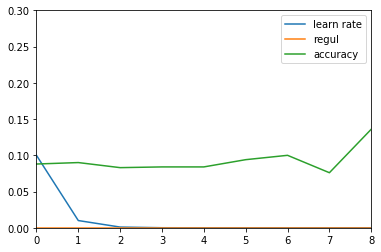

In [19]:
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,0.3)

In [23]:
test_class = linear_classifer.LinearSoftmaxClassifier()
test_pred = test_class.pred_rand(val_X)
accuracy = multiclass_accuracy(test_pred, val_y)
print(accuracy)

0.096


# Какой же точности мы добились на тестовых данных?

In [21]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

AttributeError: 'NoneType' object has no attribute 'predict'

In [18]:
np.__version__

'1.17.0'